In [1]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns
from ModelDiagnostics import Plot
from sklearn.cluster import DBSCAN
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale
from scipy import stats
from scipy.special import boxcox, inv_boxcox

INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [173]:
#power = PowerTransformer(method='box-cox')

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    return inv_boxcox(data, lambdas.values)
    
def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def revert_boxcox (data, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data.iloc[:,i]
        else:
            revert = pd.DataFrame(inv_boxcox(data.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data.columns
    return reverted


The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
3.808144164451117
The null hypothesis cannot be rejected
The null hypothesis can be rejected
-1.001341730447453
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.027108447248549845



The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


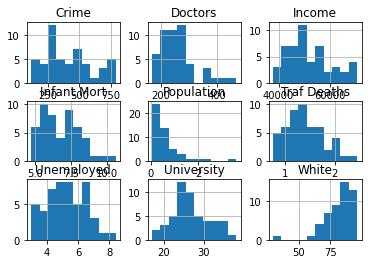

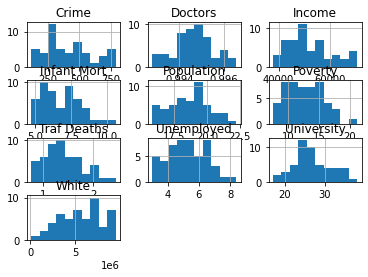

In [176]:
all_data = pd.read_csv('/mnt/distvol/states.csv')
all_data.index = all_data.iloc[:,0]

transformed, lambdas = transform_boxcox(all_data.iloc[:,1:])

transformed.columns = all_data.iloc[:,1:].columns
all_data.iloc[:,2:].hist()
transformed.hist()
transformed.to_csv("/mnt/distvol/transformed.csv")

reverted = revert_boxcox(transformed,lambdas)


In [4]:
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [191]:
trf = zca.ZCA().fit(transformed.iloc[:,1:])

X = pd.DataFrame(trf.transform(transformed.iloc[:,1:]))
X.columns=pd.DataFrame(transformed.iloc[:,1:]).columns
X.index = all_data.index
#from sklearn.preprocessing import StandardScaler

y = pd.DataFrame((transformed.iloc[:,0]-np.mean(transformed.iloc[:,0]))/np.std(transformed.iloc[:,0]))
y.columns=pd.DataFrame(transformed.iloc[:,0]).columns
y.index = all_data.index

#backwards step
max_pvalue = 1
New_Names = X.columns
X_b = X
while (max_pvalue > .05):
        
    model = sm.OLS(y,sm.tools.tools.add_constant(X_b, prepend=True, has_constant='skip'))        
    results = model.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        trf = zca.ZCA().fit(transformed[New_Names])
    
        X_b = pd.DataFrame(trf.transform(transformed[New_Names]))
        X_b.columns=pd.DataFrame(transformed[New_Names]).columns
        X_b.index = transformed.index

print(results.summary())

data = pd.concat([y,X_b],axis=1)
print(data.columns)
data.index = all_data.index
Path="/mnt/distvol"
filename="data"
data.to_csv("/mnt/distvol/data.csv",index=False)


0.9252267413537292
0.7352020565009149
0.596282974973262
0.21070066661079634
0.1345002468353412
                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     74.05
Date:                Sat, 08 May 2021   Prob (F-statistic):           3.28e-19
Time:                        19:38:28   Log-Likelihood:                -20.300
No. Observations:                  50   AIC:                             50.60
Df Residuals:                      45   BIC:                             60.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     74.05
Date:                Sat, 08 May 2021   Prob (F-statistic):           3.28e-19
Time:                        19:48:28   Log-Likelihood:                -20.300
No. Observations:                  50   AIC:                             50.60
Df Residuals:                      45   BIC:                             60.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.396e-16      0.

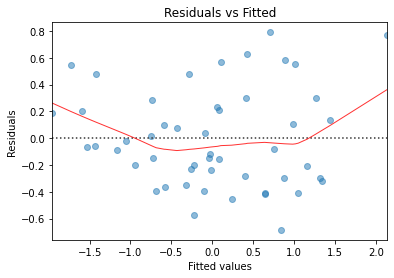

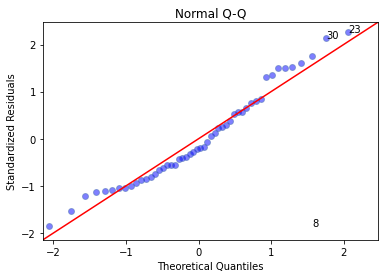

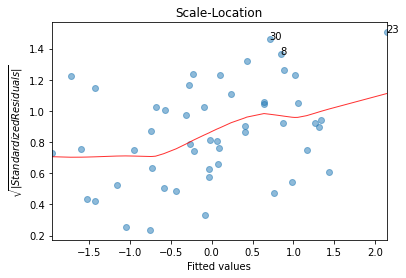

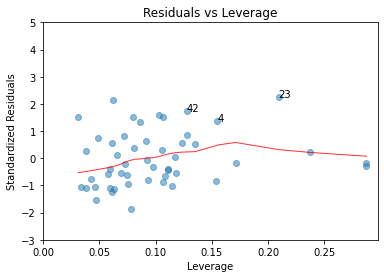

In [192]:
linear_plot = Plot.LinearRegressionResidualPlot(X_b, y)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))



Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.

The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.


array([[<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Population'}>],
       [<AxesSubplot:title={'center':'Poverty'}>,
        <AxesSubplot:title={'center':'Unemployed'}>],
       [<AxesSubplot:title={'center':'White'}>, <AxesSubplot:>]],
      dtype=object)

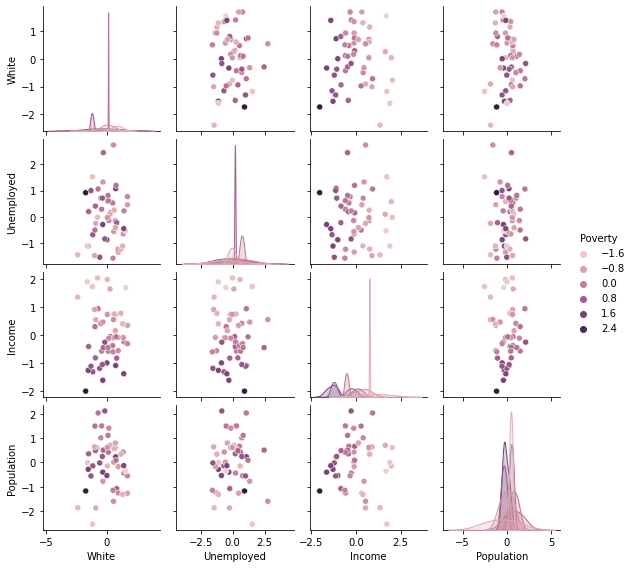

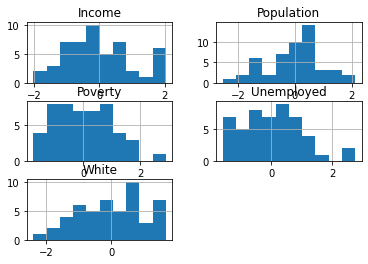

In [195]:
%matplotlib inline

sns.pairplot(pd.concat([y,X_b],axis=1), hue='Poverty', height=2);

pd.concat([y,X_b],axis=1).hist()

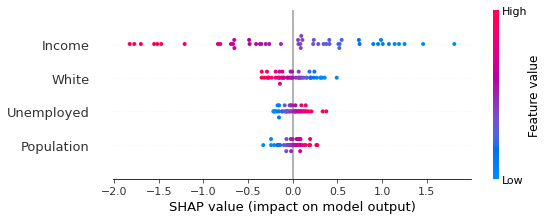

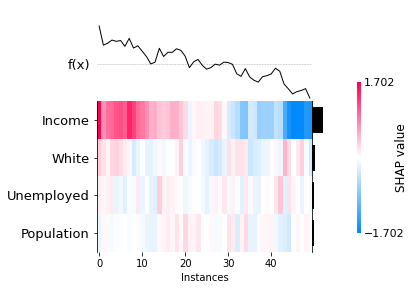

In [196]:

model = sklearn.linear_model.LinearRegression()
model.fit(X_b, y)

shap.initjs()
e = shap.explainers.Linear(model, X_b)

shap_values = e.shap_values(X_b)
shap.summary_plot(shap_values, X_b)
shap.plots.heatmap(e(X_b))

In [199]:
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(scale(transformed))
#pca.explained_variance_
print(pca.explained_variance_ratio_.cumsum())

X_pca = pd.DataFrame(pca.transform(scale(transformed)))

X_pca.index = all_data.index

scaled_pca_var = (1-(1-pca.explained_variance_ratio_.cumsum()))/sum(1-(1-pca.explained_variance_ratio_.cumsum()))

pca_scaled = pd.DataFrame()
for i in range(0,len(X_pca.columns)):
    #inner_scale = pd.DataFrame(X_pca.iloc[:,i].*scaled_pca_var[i])
    inner_scale = X_pca.iloc[:,i] * pca.explained_variance_ratio_[i]
    #plt.plot(pd.DataFrame(st.norm.ppf(ecdf[i].y)).mul(pca.explained_variance_ratio_[i],axis=0))
    #plt.show()
    pca_scaled = pd.concat([pca_scaled,inner_scale],axis=1)
    
pca_scaled.index = all_data.index


[0.43006205 0.67448932 0.77861908 0.8378841  0.89333174 0.93299362
 0.9642088  0.98085949 0.99530264]


[1] "Minnesota"
[1] 0.002583824
[1] "Colorado"
[1] 0.009032515
[1] "Washington"
[1] 0.01771935
[1] "Connecticut"
[1] 0.006435666
[1] "Massachusetts"
[1] 0.00696968
[1] "New Jersey"
[1] 0.0190019
[1] "Virginia"
[1] 0.009214945
[1] "Hawaii"
[1] 0.1009399
[1] "Maryland"
[1] 0.05662809
[1] "New York"
[1] 0.09681777
[1] "California"
[1] 0.0313794
[1] "Illinois"
[1] 0.1295247
[1] "Pennsylvania"
[1] 0.2319989
[1] "Michigan"
[1] 0.03562603
[1] "Ohio"
[1] 0.09055581
[1] "North Carolina"
[1] 0.007295679
[1] "Tennessee"
[1] 0.002883399
[1] "South Carolina"
[1] 0.01563685
[1] "Louisiana"
[1] 0.02143581
[1] "Alabama"
[1] 0.006031162
[1] "Mississippi"
[1] 0.02109671
[1] "Arkansas"
[1] 0.01233633
[1] "Oklahoma"
[1] 0.01626086
[1] "New Mexico"
[1] 0.03109894
[1] "Arizona"
[1] 0.03176813
[1] "Indiana"
[1] 0.009070839
[1] "Kentucky"
[1] 0.06791258
[1] "West Virginia"
[1] 0.03950839
[1] "Montana"
[1] 0.03913906
[1] "Idaho"
[1] 0.1223339
[1] "South Dakota"
[1] 0.04247455
[1] "Wyoming"
[1] 0.04874336
[1] "

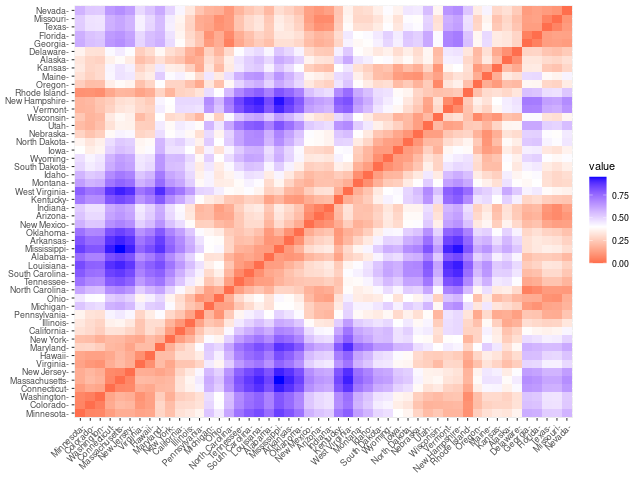

In [223]:

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

grdevices = importr('grDevices')

grdevices.png(file="/mnt/distvol/rplot.jpg", width=640, height=480)
ro.r('''
eq <- function(values) {
library(cluster)
#library(rgl,lib.loc = "/mnt/distvol/R-4.0.5/library")
#library(pca3d,lib.loc = "/mnt/distvol/R-4.0.5/library")
library(backports,lib.loc = "/mnt/distvol/R-4.0.5/library")
library(dplyr,lib.loc = "/mnt/distvol/R-4.0.5/library")
library("factoextra",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("dbscan",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("mclust",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("ggpubr",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("FactoMineR",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("reshape2",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("data.table",lib.loc = "/mnt/distvol/R-4.0.5/library")
library("NbClust",lib.loc = "/mnt/distvol/R-4.0.5/library")

#data <- read.csv("/mnt/distvol/pca_dist_scaled.csv", row.names=1)
#data2 <- read.csv("/mnt/distvol/states.csv", row.names=1)

data <- values

returnNorm <- function(df)
{
  #print(rownames(df))
  d <- lapply(data[,1:ncol(df)], function(x)
  {
    pnorm(x, mean=0, sd=1, lower.tail=TRUE, log.p =FALSE)
  })
  
  d_ <- data.frame(do.call(cbind, d))
  
  rownames(d_) <- rownames(df)
  #print(rownames(d_))
  return(d_)
   
}

df <- returnNorm(data)
#df2 <- returnNorm(data2[,1:10])

m = (get_dist(df, method = "pearson"))

m = (as.matrix(m))
nm = m

names = rownames(df)
new_names = names

mi = (min(nm[nm>0]))

s = which(( nm == mi), arr.ind=T )

removed = c()

states <- c()

first = new_names[s[1]]

while(length(removed)<49)
{
  states <- c(states, first)
  removed = c(removed,first)
  print(first)

  nm = m[which(names %in% new_names),which(names %in% new_names)]
  second_column = nm[,which(new_names==first)]
  
  column_min = min(second_column[second_column>0])
  print(column_min)
    
  column_min_id = data.frame(which(second_column == column_min))[,1]
  
  column_min_name = new_names[column_min_id]
  
  new_names = names[-which(names %in% removed)]
  
  first = column_min_name
  
}

states <- c(states,rownames(df)[-which(names %in% states)])

keyDF <- data.frame(key=states,weight=1:length(states))

df['States'] = names

merged <- merge(df,keyDF,by.x='States',by.y='key',all.x=T,all.y=F)
res <- merged[order(merged$weight),2:10]
rownames(res) <- states

dist.eucl <- dist(res, method = "euclidean")

plot(fviz_dist(dist.eucl,show_labels = TRUE, order = FALSE))
return(states)

}
''')
r_eq = ro.globalenv['eq']
p=ro.conversion.rpy2py(r_eq(ro.conversion.py2rpy(pca_scaled)))
#p = ro.r('eq(1)')            # OUTPUTS TO FILE
print(p)
grdevices.dev_off()
from IPython.display import Image
Image("/mnt/distvol/rplot.jpg")




K=1 fitted in 4.416666030883789 seconds.
K=2 fitted in 1.5849556922912598 seconds.
K=3 fitted in 1.780456304550171 seconds.
K=4 fitted in 2.012951374053955 seconds.
K=5 fitted in 2.17797589302063 seconds.
K=6 fitted in 2.3962252140045166 seconds.
K=7 fitted in 2.604462146759033 seconds.
K=8 fitted in 2.8510890007019043 seconds.
K=9 fitted in 3.122684955596924 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

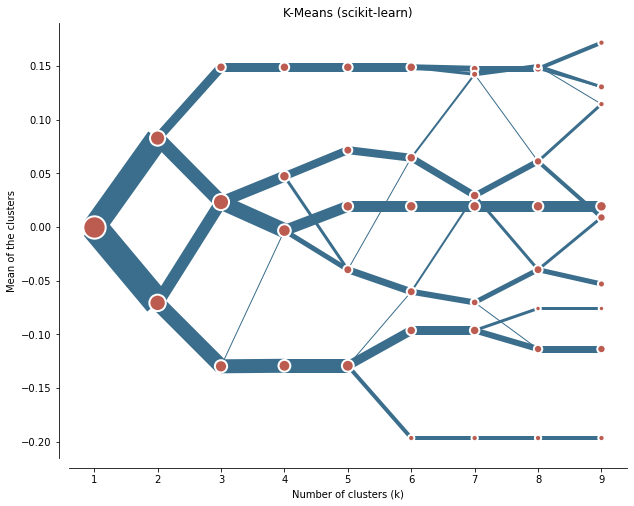

In [216]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import QuantileTransformer

cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(pca_scaled)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=False
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')


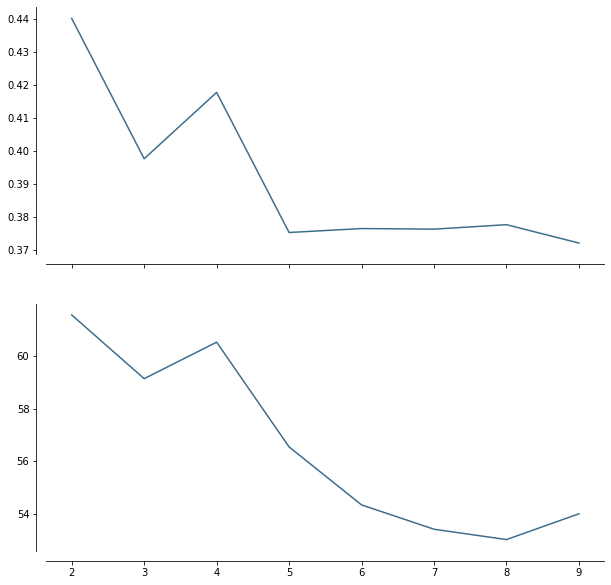

In [217]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster_pca = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]



          Poverty  Infant Mort      White       Crime     Doctors  \
labels                                                              
0       10.670370     6.114815  83.114815  342.962963  291.007407   
1       15.152174     7.669565  80.608696  483.217391  224.200000   

        Traf Deaths  University  Unemployed        Income  count  
labels                                                            
0          1.166667   30.059259    4.992593  57441.888889     27  
1          1.683478   23.278261    5.595652  45579.304348     23  
Index(['Alaska', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Hawaii',
       'Illinois', 'Iowa', 'Kansas', 'Maine', 'Maryland', 'Massachusetts',
       'Minnesota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New York',
       'North Dakota', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming'],
      dtype='object', name='States')


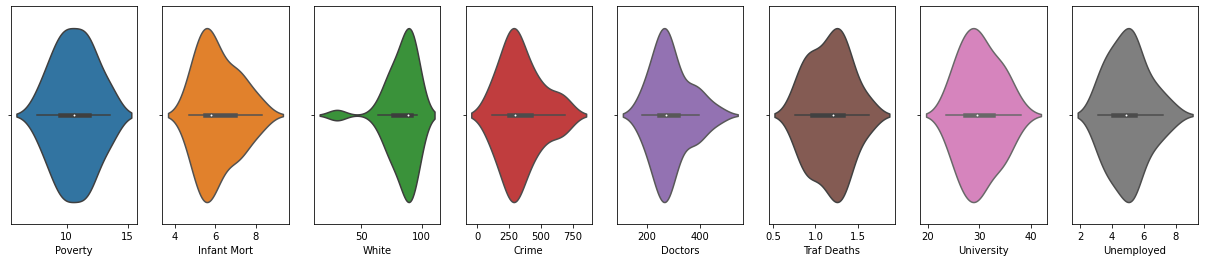

Index(['Alabama', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Idaho',
       'Indiana', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi',
       'Missouri', 'Montana', 'Nevada', 'New Mexico', 'North Carolina', 'Ohio',
       'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
       'West Virginia'],
      dtype='object', name='States')


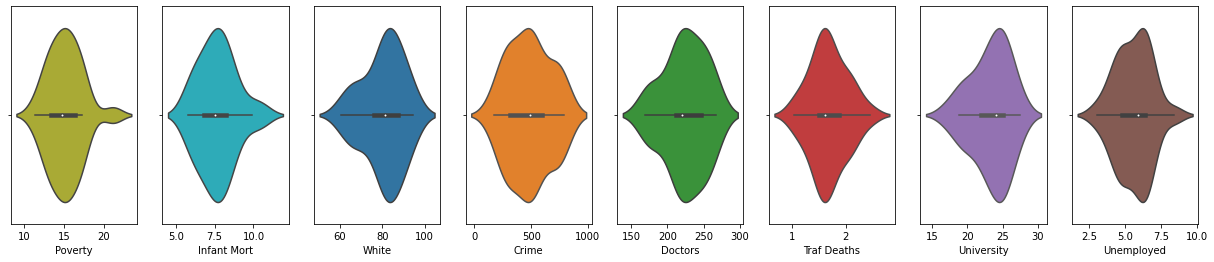

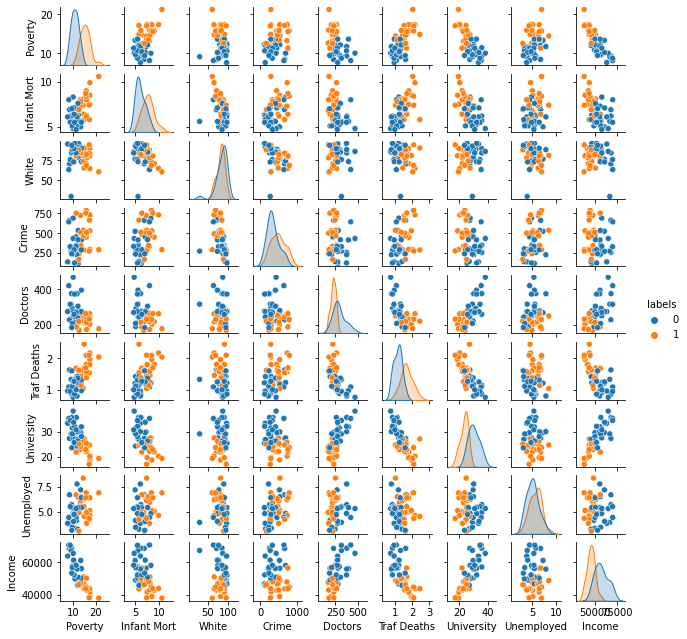

In [230]:
from itertools import cycle
import matplotlib.pyplot as plt

all_data2 = all_data.iloc[:,1:10]

cluster_pca.index = all_data2.index

pca_scaled['labels'] = pd.DataFrame(cluster_pca)
transformed['labels'] = pd.DataFrame(cluster_pca)
transformed.to_csv("transformed.csv")
pca_scaled.to_csv("pca_dist_scaled.csv")
all_data2['labels'] = pd.DataFrame(cluster_pca)

#all_data2 = all_data2.loc[X_pca.index]

summary_set2 = all_data2[all_data2['labels']>=-1][all_data2.columns].groupby('labels').mean()
summary_set2["count"] = pd.DataFrame(all_data2[all_data2['labels']>=-1][all_data2.columns].groupby('labels').count())[all_data2.columns[0]]
print(summary_set2)

%matplotlib inline 

#fig, axes = plt.subplots((cgram.calinski_harabasz_score()).idxmax(axis=1), len(all_data2.columns), sharex=True, figsize=(16,8))
#fig, axes = plt.subplots(len(all_data2.columns)-2,(cgram.calinski_harabasz_score()).idxmax(axis=1), sharex=True, figsize=(16,32))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

for i in range(0,(cgram.calinski_harabasz_score()).idxmax(axis=1)):
        fig = plt.figure(figsize=(24,4))  
        group = all_data2.loc[all_data2.index[cluster_pca==i]]
        #groupmean = group.iloc[:,0].mean()        
        print(group.index)
        for j in range(0,len(all_data2.columns)-2):                
            plt.subplot(1,len(all_data2.columns)-1,j+1)
            #plt.subplot(1,2,2)
            
            sns.violinplot(x=group[group.columns[j]],color=next(colors))
            #sns.violinplot(ax=axes[j,0], x=group[group.columns[j]])     
            #print(i,j)

        plt.show()
        
sns.pairplot(all_data2, hue='labels', height=1);
    

        

In [ ]:
# evaluate an elastic net model on the dataset
tsize = .3
train, test = train_test_split(all_data, test_size=tsize, shuffle=True)

std_ = np.std(train.iloc[:,1])
mean_ = np.mean(train.iloc[:,1])
y_train = pd.DataFrame((train.iloc[:,1]-mean_)/std_)
y_train.columns=pd.DataFrame(train.iloc[:,1]).columns
y_train.index = train.index

#StandardScaler().fit_transform(all_data.iloc[:,1])

#exclude y
trf = zca.ZCA().fit(all_data.iloc[:,2:])

X_train = pd.DataFrame(trf.transform(train.iloc[:,2:]))
X_train.columns=pd.DataFrame(train.iloc[:,2:]).columns
X_train.index = train.index

y_test = pd.DataFrame((test.iloc[:,1]-np.mean(train.iloc[:,1]))/np.std(train.iloc[:,1]))
y_test.columns=pd.DataFrame(test.iloc[:,1]).columns
y_test.index = test.index

X_test = pd.DataFrame(trf.transform(test.iloc[:,2:]))
X_test.columns=pd.DataFrame(test.iloc[:,2:]).columns
X_test.index = test.index


In [ ]:

'''
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
'''

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, verbose=0)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

# define model
model = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_)

# fit model
model.fit(X_train, y_train)

# define new data
#row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
# make a prediction
yhat = model.predict(X_test)
# summarize prediction
#print('Predicted: %.3f' % yhat)

In [ ]:
coef = pd.DataFrame(model.coef_).set_index(X_train.columns)
a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
a_coef

In [ ]:
print(model.score(X_train, y_train, sample_weight=None))
print(model.score(X_test, y_test, sample_weight=None))
print(model.score(X, y, sample_weight=None))
print(model.coef_)

In [ ]:
import matplotlib.pyplot as plt
predicted = pd.DataFrame(yhat*std_+mean_)
predicted.index = y_test.index
predicted.columns = y_test.columns
actual = pd.DataFrame(y_test*std_+mean_)
actual.index = y_test.index
plt.scatter(predicted, actual)

plt.show()

plt.hist(predicted-actual, bins='auto')  # arguments are passed to np.histogram

rmse = mean_squared_error(actual, predicted, squared=True)
mape = MAPE(actual, predicted)

print("rmse",rmse)
print("mape",mape)

In [ ]:
%matplotlib inline
shap.initjs()

# select a set of background examples to take an expectation over
background = np.array(data)
#[np.random.choice(X_train.shape[0],100,replace=False)]

#model = sklearn.linear_model.LinearRegression()
#model.fit(data.iloc[:,1:], data.iloc[:,0])

# explain predictions of the model on four images
e = shap.LinearExplainer(model, X_train)
#explainer = shap.KernelExplainer(model, X_train, link="logit")
print(y_test.columns)
shap_values = e.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
explainer = shap.Explainer(model, X_train)
shap.plots.heatmap(explainer(X_test))

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

pre_list = feature_importance[feature_importance["feature_importance_vals"]>.025]["col_name"].values.tolist()
pre_list.insert(0,all_data.columns[1])

In [ ]:
set_ = data[pre_list]
set_.index = all_data.iloc[:,0]
#set_ = data[["Poverty","Income"]]

In [ ]:
n=2

In [ ]:
all_data = pd.read_csv('/mnt/distvol/states.csv')
all_data.index = all_data.iloc[:,0]

trf = zca.ZCA().fit(all_data.iloc[:,1:])

white_data = pd.DataFrame(trf.transform(all_data.iloc[:,1:]))
white_data.index = all_data.index
white_data.columns = all_data.iloc[:,1:].columns
white_data.index = all_data.index

eps_tries = arange(0.1, 5, 0.1)
clusters = []

for i in range(0,len(eps_tries)):
    
    db = DBSCAN(eps=eps_tries[i], min_samples=2).fit(white_data)
    labels = db.labels_
    #print (labels)
    realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
    clusterNum = len(set(labels))
    clusters.append(clusterNum)

max_e = pd.DataFrame(clusters)[0].idxmax(axis=1)

db = DBSCAN(eps=eps_tries[max_e], min_samples=2).fit(white_data)
labels = db.labels_
print (labels)
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

white_data["clusters"] = labels
all_data['clusters'] = labels

sns.pairplot(white_data, height=2, hue="clusters");

white_data.hist()

summary_set_w = all_data[white_data['clusters']>=-1][white_data.columns].groupby('clusters').mean()
summary_set_w["count"] = pd.DataFrame(all_data[white_data['clusters']>=-1][white_data.columns].groupby('clusters').count())[white_data.columns[0]]
summary_set_w

In [ ]:
from sklearn.preprocessing import scale

data_set = scale(all_data.iloc[:,1:])
#data_set = white_data

cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(data_set)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=True
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')


In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster-pca = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]

In [ ]:
cgram = Clustergram(range(1, 10), n_init=100, method="gmm")
cgram.fit(data_set)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
    pca_weighted=True
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title("Gaussian Mixture Model (scikit-learn)")

In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
cgram.silhouette_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
cgram.calinski_harabasz_score().plot(
    #xlabel="Number of clusters (k)",
    #ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

cluster-gmm = cgram.labels.iloc[:,(cgram.calinski_harabasz_score()).idxmax(axis=1)-1]

In [ ]:
summary_set = all_data[all_data['clusters']>=-1][set_.columns].groupby('clusters').mean()
summary_set["count"] = pd.DataFrame(all_data[all_data['clusters']>=-1][set_.columns].groupby('clusters').count())[set_.columns[0]]
summary_set

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

sns.set(style = "darkgrid")

fig = plt.figure(figsize=[16,16])
ax = fig.add_subplot(111, projection = '3d')

x = set_.iloc[:,1]
y = set_.iloc[:,2]
z = set_.iloc[:,3]

m = np.array([x,y,z])
scatter = ax.scatter(x,y,z, c=set_.iloc[:,0], cmap="RdYlGn", s=(set_['clusters']+2)*40, edgecolors="black")

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

#legend2 = ax.legend(*scatter.legend_elements(prop="sizes", alpha=0.6),loc="upper left", title="clusters")

legend2 = ax.legend(handles, range(0,len(labels)), loc="upper right", title="clusters")
#ax.legend()
ax.add_artist(legend2)
    
states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
for i in range(len(m[0]-1)): #plot each point + it's index as text above 
    #ax.scatter(m[0,i],m[1,i],m[2,i], marker=set_.iloc[i]['clusters']+2, s=100, color='k') 
    ax.text(m[0,i],m[1,i],m[2,i],  '%s' % (str(states[i])), size=10, zorder=1,  color='k') 
   
#legend1 = ax.legend(*scatter.legend_elements(num=5),loc="upper left", title="Ranking")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Poverty")
ax.add_artist(legend1)


#kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}",func=lambda s: np.sqrt(s/.3)/3)

#legend2 = ax.legend(*scatter.legend_elements(**kw),loc="lower right", title="Price")

ax.legend()
ax.set_xlabel(set_.columns[1])
ax.set_ylabel(set_.columns[2])
ax.set_zlabel(set_.columns[3])
plt.show()


In [ ]:

from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

%matplotlib inline
sns.set(style='whitegrid')

#iris = sns.load_dataset(pd.concat([y,X_b],axis=1))
g = sns.pairplot(set_, hue="clusters")
g.fig.suptitle("Data", y=1.01)

In [ ]:
# Violin Plots of Minimum and Maximum Temperature
from itertools import cycle

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

%matplotlib inline 
for i in range(-1,clusterNum-1):
    print("cluster:")
    print(i)
    fig = plt.figure(figsize=(6,4))    
    for j in range(0,len(set_.columns)-1):                
        #plt.subplot(1,2,1)
        sns.violinplot(x=all_data[all_data['clusters']==i][set_.columns[j]],color=next(colors))
        plt.show()
